# *Coastal Erosion*: example at Marina Beach, Tamil Nadu, India



## Initial settings

Refer to the **Installation** section of the README for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.

In [1]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AY0e-g4dqKGMQ2ImA42IchFrwJLsGAdjsngyho0fkV04vrAyoRBtlnmjjvg

Successfully saved authorization token.


In [2]:
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects

## 1. Retrieval of the images from GEE

Define the region of interest (`polygon`), the date range (`dates`) and the satellite missions (`sat_list`) from which you wish to retrieve the satellite images. The images will be cropped on the Google Earth Engine server and only the region of interest will be downloaded as a .tif file. The files will stored in the directory defined in `filepath`. 

Make sure the area of your ROI is smaller than 100 km2 (if larger split it into smaller ROIs).

The function `SDS_download.check_images_available(inputs)` will print the number of images available for your inputs. The Landsat images are divided in Tier 1 and Tier 2, only Tier 1 images can be used for time-series analysis. 

In [3]:
# region of interest (longitude, latitude)
polygon = [[[80.26299652463311,13.073613307239038], 
            [80.3047102390004 ,13.06508535029892],   
            [80.29346467621008, 13.013969479277938],  
            [80.26342393541059, 13.01614374943183],    
            ]] 
# it's recommended to convert the polygon to the smallest rectangle (sides parallel to coordinate axes)       
polygon = SDS_tools.smallest_rectangle(polygon)
# date range
dates = ['2018-12-01', '2021-01-01']
# satellite missions
sat_list = ['S2']
# name of the site
sitename = 'MARINA'
# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'data')
# put all the inputs into a dictionnary
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath}

# before downloading the images, check how many images are available for your inputs
SDS_download.check_images_available(inputs);

Images available between 2018-12-01 and 2021-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
  S2: 124 images
  Total: 124 images


The function `SDS_download.retrieve_images(inputs)` retrives the satellite images from Google Earth Engine.

By default, only Landsat Tier 1 Top-of-Atmosphere and Sentinel-2 Level-1C products are downloaded. 

In case you need to access Tier 2 images for qualitative analysis, you need to set `inputs['include_T2'] = True` before calling `retrieve_images`.

In [4]:
# inputs['include_T2'] = True
metadata = SDS_download.retrieve_images(inputs)

Images available between 2018-12-01 and 2021-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
  S2: 124 images
  Total: 124 images

S2: 124 images
100%
1 out of 124 Sentinel-2 images were merged (overlapping or duplicate)


**If you have already retrieved the images**, just load the metadata file by only running the section below

In [7]:
metadata = SDS_download.get_metadata(inputs) 

## 2. Shoreline extraction

This section maps the position of the shoreline on the satellite images. The user can define the cloud threhold (`cloud_thresh`) and select the spatial reference system in which to output the coordinates of the mapped shorelines (`output_epsg`). See http://spatialreference.org/ to find the EPSG number corresponding to your local coordinate system. Make sure that your are using cartesian coordinates and not spherical coordinates (lat,lon) like WGS84. If unsure, use 3857 which is the web mercator projection (used by Google Maps).

To quality control each shoreline detection and manually validate the mapped shorelines, the user has the option to set the parameter `check_detection` to **True**. 
To adjust the position of each shoreline by modifying the threshold defining the sand/water interface you can set `adjust_detection` to **True**. 
Finally, to save a figure for each mapped shoreline as a .jpg in the folder */jpg_files/detection* set `save_figure` to **True**. 

The other parameters are for advanced users only and are described in the README.

In [8]:
settings = { 
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
    'output_epsg': 3857,        # epsg code of spatial reference system desired for the output   
    # quality control:
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 4500,     # minimum area (in metres^2) for an object to be labelled as a beach
    'buffer_size': 150,         # radius (in metres) for buffer around sandy pixels considered in the shoreline detection
    'min_length_sl': 200,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    # add the inputs defined previously
    'inputs': inputs
}

### Save .jpg of the satellite images 
Saves .jpg files of the preprocessed satellite images (cloud masking + pansharpening/down-sampling) under *./data/sitename/jpeg_files\preprocessed*

In [9]:
SDS_preprocess.save_jpg(metadata, settings)

Satellite images saved as .jpg in C:\Users\lenovo\Documents\CoastSat-master\data\MARINA\jpg_files\preprocessed


###  Digitize a reference shoreline
Creates a reference shoreline which helps to identify outliers and false detections. The reference shoreline is manually digitised by the user on one of the images. The parameter `max_dist_ref` defines the maximum distance from the reference shoreline (in metres) at which a valid detected shoreline can be. If you think that the default value of 100 m will not capture the full shoreline variability of your site, increase this value to an appropriate distance.

In [11]:
%matplotlib qt
settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
settings['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference shoreline

Reference shoreline has been saved in C:\Users\lenovo\Documents\CoastSat-master\data\MARINA


### Batch shoreline detection
Extracts the 2D shorelines from the images in the spatial reference system specified by the user in `'output_epsg'`. The mapped shorelines are saved into `output.pkl` (under *./data/sitename*) and `output.geojson` (to be used in a GIS software).

If you see that the sand pixels on the images are not being identified, change the parameter `sand_color` from `default` to `dark` or `bright` depending on the color of your beach. 

In [12]:
%matplotlib qt
output = SDS_shoreline.extract_shorelines(metadata, settings)

Mapping shorelines:
S2:   100%


Then remove duplicates and images with inaccurate georeferencing (threhsold at 10m)

In [13]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

0 duplicates
0 bad georef


For use in GIS applications, you can save the mapped shorelines as a GEOJSON layer which can be easily imported into QGIS for example. You can choose to save the shorelines as a collection of lines or points (sometimes the lines are crossing over so better to use points).

In [14]:
geomtype = 'lines' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
gdf.crs = {'init':'epsg:'+str(settings['output_epsg'])} # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

Simple plot of the mapped shorelines. The coordinates are stored in the output dictionnary together with the exact dates in UTC time, the georeferencing accuracy and the cloud cover.

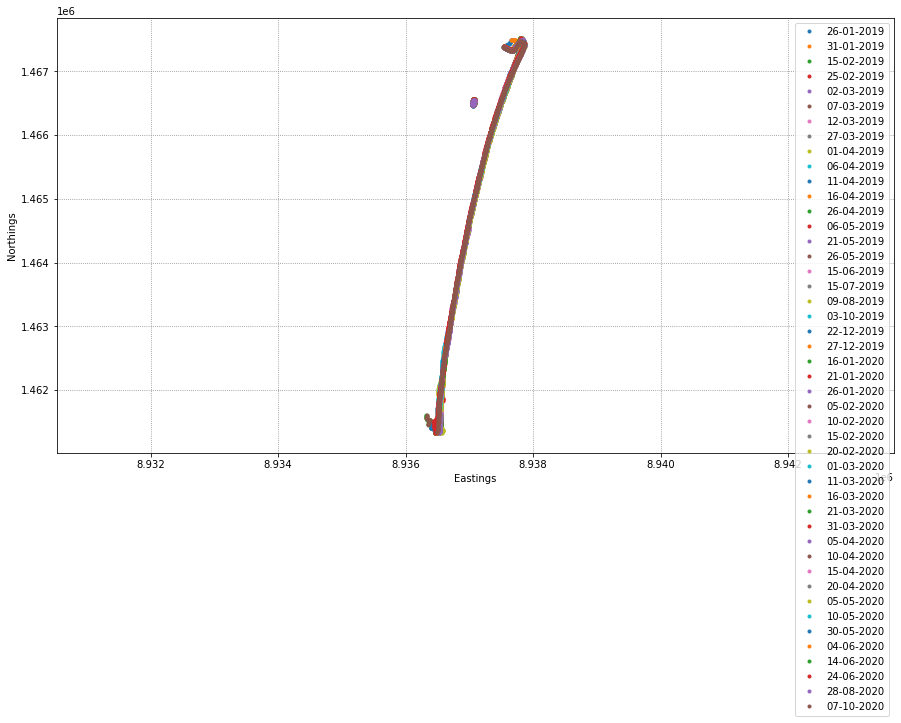

In [16]:
%matplotlib inline

fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
plt.legend();

## 3. Shoreline analysis

In this section we show how to compute time-series of cross-shore distance along user-defined shore-normal transects.

**If you have already mapped the shorelines**, just load the output file (`output.pkl`) by running the section below

In [17]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f) 

There are 3 options to define the coordinates of the shore-normal transects:

**Option 1**: the user can interactively draw the shore-normal transects along the beach by calling:

In [18]:
%matplotlib qt
transects = SDS_transects.draw_transects(output, settings)

Transect locations saved in C:\Users\lenovo\Documents\CoastSat-master\data\MARINA


**Option 2**: the user can load the transect coordinates (make sure the spatial reference system is the same as defined previously by the parameter *output_epsg*) from a .geojson file by calling:

In [19]:
geojson_file = os.path.join(os.getcwd(), 'examples', 'NARRA_transects.geojson')
transects = SDS_tools.transects_from_geojson(geojson_file)

5 transects have been loaded


Plot the time-series of shoreline change along each transect